In [ ]:
import sys
import os
import pandas as pd
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))
from utils.utils import save_experiment, train_and_evaluate_logistic_regression, evaluate_model_on_parquet, grid_search_joblib
from configs.config_local import DATASET_PATH, FEATURES_DIR, ITW_DATASET_PATH, MODELS_PATH


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np

import matplotlib.pyplot as plt
import joblib


In [2]:
train_data_path = os.path.join(FEATURES_DIR, "training_features_20_128_256_128.parquet")
test_data_path = os.path.join(FEATURES_DIR, "testing_features_20_128_256_128.parquet")

In [3]:


df = pd.read_parquet(train_data_path)
df_test = pd.read_parquet(test_data_path)

lr_params = {
            "C": 10.0,  # Regularization strength
            "class_weight": "balanced",  # Handle imbalanced classes
            "max_iter": 1000,  # Usually enough to converge
            "random_state": 42,
            "solver": "liblinear",  # Good for small-medium datasets, handles binary classification well
            "penalty": "l2",  # Standard L2 regularization
        }

pipeline, metrics, lr_params, feature_names, metadata_extra = train_and_evaluate_logistic_regression(train_data_path, test_data_path, lr_params)

In [4]:
print(metrics)

{'accuracy': 0.7224859732412603, 'precision': 0.7268717825551044, 'recall': 0.7239309835845597, 'f1': 0.7218817116482245, 'roc_auc': 0.7991253671482459}


In [5]:
save_experiment(
    model=pipeline,
    metrics=metrics,
    experiment_dir=os.path.join(sys.path[0], "notebooks", "experiments",  "logistic_reg",),
    model_params=lr_params,
    feature_names=feature_names,
    metadata_extra=metadata_extra,
)


Experiment saved to: c:\Users\Konstantinos\Documents\GitHub\audio-deepfake-detection\notebooks\experiments\logistic_reg\exp_20260131_215340


'c:\\Users\\Konstantinos\\Documents\\GitHub\\audio-deepfake-detection\\notebooks\\experiments\\logistic_reg\\exp_20260131_215340'

In [6]:
# test model on itw data
test_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_20_128_256_128_trimmed_loudness_normalized.parquet")
metrics,_=evaluate_model_on_parquet(pipeline, test_path)
metrics


{'accuracy': 0.7131891137473831,
 'precision': 0.8682025180819716,
 'recall': 0.2748706640658129,
 'f1_macro': 0.6136506370445688,
 'roc_auc': 0.7505377556155657}

#### Train model without mel spectrogram featuress

In [7]:
train_data_path = os.path.join(FEATURES_DIR, "training_features_20_128_256_128.parquet")
test_data_path = os.path.join(FEATURES_DIR, "testing_features_20_128_256_128.parquet")

train_data = pd.read_parquet(train_data_path)
test_data = pd.read_parquet(test_data_path)


In [8]:
train_data_no_mel = train_data.loc[:, ~train_data.columns.str.startswith("mel_spectrogram")]
test_data_no_mel = test_data.loc[:, ~test_data.columns.str.startswith("mel_spectrogram")]


In [9]:
save_train_no_mel_data_path = os.path.join(FEATURES_DIR, "training_features_20_128_256_128_no_mel.parquet")
train_data_no_mel.to_parquet(save_train_no_mel_data_path)

save_test_no_mel_data_path = os.path.join(FEATURES_DIR, "testing_features_20_128_256_128_no_mel.parquet")
test_data_no_mel.to_parquet(save_test_no_mel_data_path)


In [ ]:
train_data_path = save_train_no_mel_data_path
test_data_path = save_test_no_mel_data_path

df = pd.read_parquet(train_data_path)
df_test = pd.read_parquet(test_data_path)


lr_params_no_mel = {
            "C": 1.0,  # Regularization strength
            "class_weight": "balanced",  # Handle imbalanced classes
            "max_iter": 1000,  # Usually enough to converge
            "random_state": 42,
            "solver": "liblinear",  # Good for small-medium datasets, handles binary classification well
            "penalty": "l2",  # Standard L2 regularization
        }

pipeline_no_mel, metrics_no_mel, lr_params_no_mel, feature_names_no_mel, metadata_extra_no_mel = train_and_evaluate_logistic_regression(train_data_path, test_data_path, lr_params)

  label                                           filename  mfcc_mean_0  \
0  real    file1.wav_16k.wav_norm.wav_mono.wav_silence.wav  -611.930420   
1  real   file10.wav_16k.wav_norm.wav_mono.wav_silence.wav  -605.008606   
2  real  file100.wav_16k.wav_norm.wav_mono.wav_silence.wav  -597.774414   
3  real  file1000.wav_16k.wav_norm.wav_mono.wav_silence...  -601.991211   
4  real  file1001.wav_16k.wav_norm.wav_mono.wav_silence...  -624.717590   

   mfcc_std_0  mfcc_mean_1  mfcc_std_1  mfcc_mean_2  mfcc_std_2  mfcc_mean_3  \
0   72.226364    12.266665   42.255665   -12.647933   31.396906    22.397125   
1   89.047852    -0.973098   43.327984   -12.821069   30.010666    38.964752   
2   55.831722     7.211399   28.566553   -16.026072   20.905310    50.700493   
3   84.732544   -23.718582   54.874195    -9.058393   29.486805    42.911995   
4   89.558777   -23.051550   46.054176   -12.977422   40.239491    38.695904   

   mfcc_std_3  ...  spectral_centroid_mean_0  spectral_centroid_std_

In [11]:
print(metrics_no_mel)

{'accuracy': 0.5489857574449719, 'precision': 0.5533157352063323, 'recall': 0.5512684319601616, 'f1': 0.5455315019562905, 'roc_auc': 0.5641137749548986}


In [12]:
save_experiment(
    model=pipeline_no_mel,
    metrics=metrics_no_mel,
    experiment_dir=os.path.join(sys.path[0], "notebooks", "experiments", "logistic_reg"),
    model_params=lr_params_no_mel,
    feature_names=feature_names_no_mel,
    metadata_extra=metadata_extra_no_mel,
)


Experiment saved to: c:\Users\Konstantinos\Documents\GitHub\audio-deepfake-detection\notebooks\experiments\logistic_reg\exp_20260131_215345


'c:\\Users\\Konstantinos\\Documents\\GitHub\\audio-deepfake-detection\\notebooks\\experiments\\logistic_reg\\exp_20260131_215345'

In [13]:
# test model on itw data

# remove mel features and save new df
test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_20_128_256_128_trimmed_loudness_normalized.parquet")
test_data = pd.read_parquet(test_data_path)
test_data_no_mel = test_data.loc[:, ~test_data.columns.str.startswith("mel_spectrogram")]
save_test_data_no_mel_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_20_128_256_128_no_mel_trimmed_loudness_normalized.parquet")
test_data_no_mel.to_parquet(save_test_data_no_mel_path)

#evaluate the model
test_path = save_test_data_no_mel_path
metrics,_ = evaluate_model_on_parquet(pipeline_no_mel, test_path)
metrics

{'accuracy': 0.7166465774281545,
 'precision': 0.8423574508864399,
 'recall': 0.29819353744381305,
 'f1_macro': 0.6253754271958196,
 'roc_auc': 0.7151433879962853}

### Train model without standar deviation of features

In [14]:

train_data_path = os.path.join(FEATURES_DIR, "training_features_20_128_256_128.parquet")
test_data_path = os.path.join(FEATURES_DIR, "testing_features_20_128_256_128.parquet")

df_train = pd.read_parquet(train_data_path)
df_test = pd.read_parquet(test_data_path)

train_data_mean = df_train.loc[:, ~df_train.columns.str.contains("_std_")]
test_data_mean = df_test.loc[:, ~df_test.columns.str.contains("_std_")]

train_data_mean.to_parquet(os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet"))
test_data_mean.to_parquet(os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet"))



df = pd.read_parquet(os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet"))
df_test = pd.read_parquet(os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet"))
#print(df.head())
print(df_test.head())
print(df_test.shape)
#df.shape()

lr_params = {
            "C": 1.0,  # Regularization strength
            "class_weight": 'balanced',  # Handle imbalanced classes
            "max_iter": 5000,  # Usually enough to converge
            "random_state": 42,
            "solver": "lbfgs",  # Good for small-medium datasets, handles binary classification well
            "penalty": "l2",  # Standard L2 regularization
        }

pipeline_mean, metrics_mean, lr_params_mean, feature_names_mean, metadata_extra_mean = train_and_evaluate_logistic_regression(os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet"),
                                                                                                                                         os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet"),
                                                                                                                                         lr_params)

print(metrics_mean)

  label                                           filename  mfcc_mean_0  \
0  real    file1.wav_16k.wav_norm.wav_mono.wav_silence.wav  -611.930420   
1  real   file10.wav_16k.wav_norm.wav_mono.wav_silence.wav  -605.008606   
2  real  file100.wav_16k.wav_norm.wav_mono.wav_silence.wav  -597.774414   
3  real  file1000.wav_16k.wav_norm.wav_mono.wav_silence...  -601.991211   
4  real  file1001.wav_16k.wav_norm.wav_mono.wav_silence...  -624.717590   

   mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  mfcc_mean_5  \
0    12.266665   -12.647933    22.397125   -18.097271     6.636819   
1    -0.973098   -12.821069    38.964752   -17.512388    -5.345759   
2     7.211399   -16.026072    50.700493   -41.957108    -4.920807   
3   -23.718582    -9.058393    42.911995   -23.795502    -0.905054   
4   -23.051550   -12.977422    38.695904   -18.944435    -0.490484   

   mfcc_mean_6  mfcc_mean_7  ...  mel_spectrogram_mean_118  \
0   -13.808917     1.950459  ...                  0.104165   
1   

Index(['label', 'filename', 'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2',
       'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6',
       'mfcc_mean_7',
       ...
       'mel_spectrogram_mean_118', 'mel_spectrogram_mean_119',
       'mel_spectrogram_mean_120', 'mel_spectrogram_mean_121',
       'mel_spectrogram_mean_122', 'mel_spectrogram_mean_123',
       'mel_spectrogram_mean_124', 'mel_spectrogram_mean_125',
       'mel_spectrogram_mean_126', 'mel_spectrogram_mean_127'],
      dtype='object', length=197)


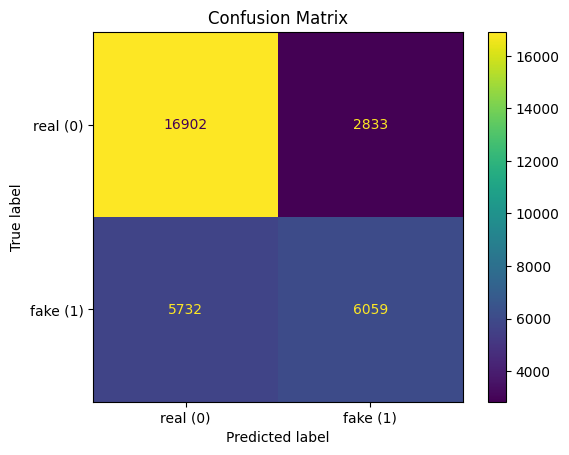

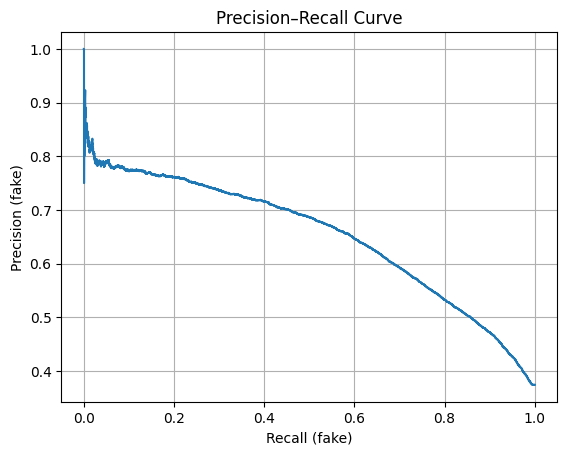

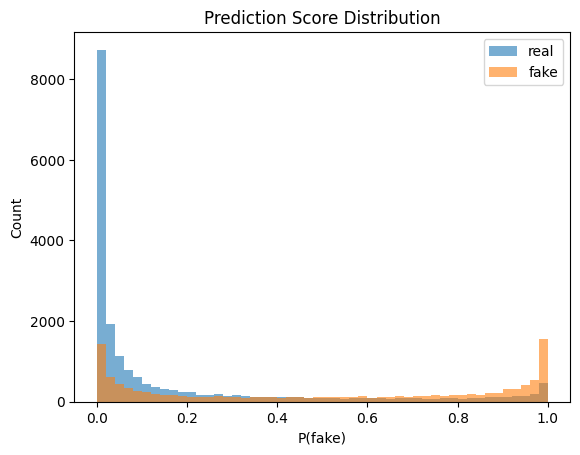

{'accuracy': 0.7283194823320434, 'precision': 0.6813990103463787, 'recall': 0.5138665083538292, 'f1_macro': 0.691869639011774, 'roc_auc': 0.7683701935042675}


In [15]:
itw_test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features',"itw_features_20_128_256_128_trimmed_loudness_normalized.parquet")
itw_data= pd.read_parquet(itw_test_data_path)
itw_data_mean = itw_data.loc[:, ~itw_data.columns.str.contains("_std_")]
print(itw_data_mean.columns)
itw_data_mean.to_parquet(os.path.join(ITW_DATASET_PATH, 'normalized_features', "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet"))

metrics, metadata_extra = evaluate_model_on_parquet(pipeline_mean, os.path.join(ITW_DATASET_PATH, 'normalized_features', "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet"), plots=True)
print(metrics)

### Grid search for hyperparameter tuning

In [16]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

train_data_path = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
val_data_path = os.path.join(FEATURES_DIR, "testing_features_mean_20_128_256_128.parquet")
test_data_path = os.path.join(ITW_DATASET_PATH, 'normalized_features', "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet")

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight={0:1, 1:5},
        random_state=42,
        n_jobs=1,
    )),
])

param_grid = {
    "clf__solver": ["saga"],
    "clf__penalty": ["l1","l2"],
    "clf__C": np.logspace(-3, 2, 10),
    "clf__max_iter": [1000],
}

final_model, test_metrics, val_metrics, best_params, val_results, metadata, feature_names = grid_search_joblib(
                                                                                                                                model,
                                                                                                                                param_grid,
                                                                                                                                train_data_path,
                                                                                                                                val_data_path,
                                                                                                                                test_data_path,
                                                                                                                                n_jobs=5
                                                                                                                            )
print(f'Best parameters:{best_params}')
print(f'Resluts on validation data:{val_metrics}')
print(f'Resluts on test data:{test_metrics}')

save_experiment(
    model=final_model,
    metrics=test_metrics,
    experiment_dir=os.path.join(sys.path[0], "notebooks", "experiments", "logistic_reg"),
    model_params=best_params,
    feature_names=feature_names,
    metadata_extra=metadata,
)

Number of fits: 20 with n_jobs=5 parallel jobs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   46.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done  14 out of  20 | elapsed:  5.9min remaining:  2.5min
[Parallel(n_jobs=5)]: Done  17 out of  20 | elapsed:  7.6min remaining:  1.3min
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  8.9min finished


[1] {'clf__C': np.float64(0.001), 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'} | val_acc=0.5645 | val_f1=0.4522
[2] {'clf__C': np.float64(0.001), 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga'} | val_acc=0.6349 | val_f1=0.5753
[3] {'clf__C': np.float64(0.003593813663804626), 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'} | val_acc=0.6398 | val_f1=0.5844
[4] {'clf__C': np.float64(0.003593813663804626), 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga'} | val_acc=0.6800 | val_f1=0.6432
[5] {'clf__C': np.float64(0.01291549665014884), 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'} | val_acc=0.6899 | val_f1=0.6589
[6] {'clf__C': np.float64(0.01291549665014884), 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga'} | val_acc=0.7095 | val_f1=0.6848
[7] {'clf__C': np.float64(0.046415888336127795), 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'} | val_acc=0.716

c:\Users\Konstantinos\anaconda3\envs\audio_deepfake\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


'c:\\Users\\Konstantinos\\Documents\\GitHub\\audio-deepfake-detection\\notebooks\\experiments\\logistic_reg\\exp_20260131_220429'

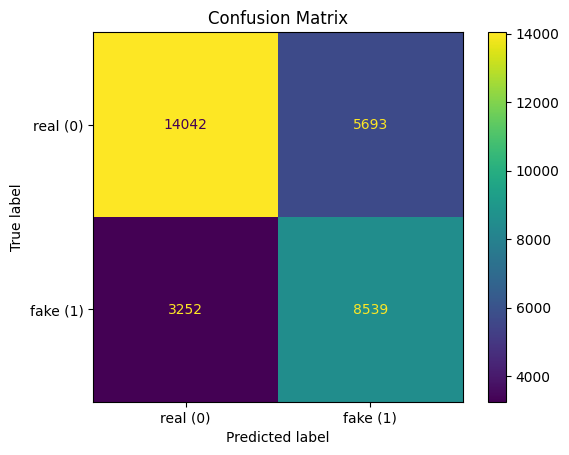

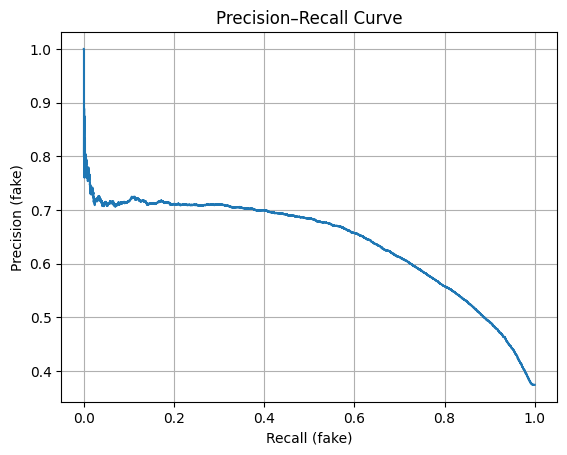

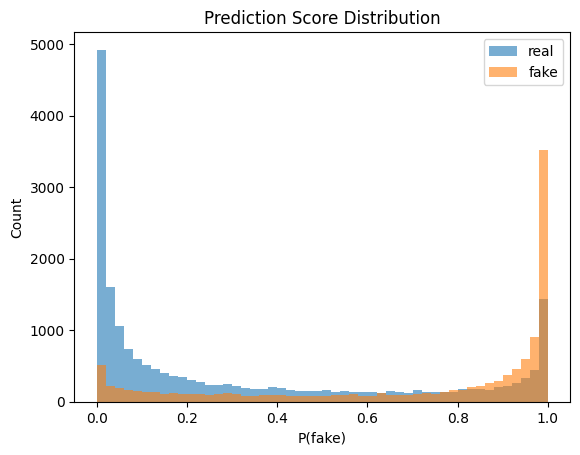

{'accuracy': 0.7162659392247669, 'precision': 0.5999859471613266, 'recall': 0.7241964209990671, 'f1_macro': 0.7073490955299664, 'roc_auc': 0.7774722347845446}


In [17]:
metrics, metadata_extra = evaluate_model_on_parquet(final_model, os.path.join(ITW_DATASET_PATH, 'normalized_features', "itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet"), plots=True)
print(metrics)

In [18]:
print(val_results)

[{'params': {'clf__C': np.float64(0.001), 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'}, 'val_accuracy': 0.5645230902028485, 'val_f1_macro': 0.4522481729523853, 'val_precision': (0.7462771731801385,), 'val_recall': (0.5544570306093543,), 'val_roc_auc': 0.8796542097180601, 'selection_score': 0.4522481729523853, 'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=np.float64(0.001),
                                    class_weight={0: 1, 1: 5}, max_iter=1000,
                                    n_jobs=1, penalty='l1', random_state=42,
                                    solver='saga'))])}, {'params': {'clf__C': np.float64(0.001), 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga'}, 'val_accuracy': 0.6348726801899007, 'val_f1_macro': 0.5752644870657293, 'val_precision': (0.7679270504731861,), 'val_recall': (0.6266312937036871,), 'val_roc_auc': 0.8993434196597637, 'selection_score': 0.5752

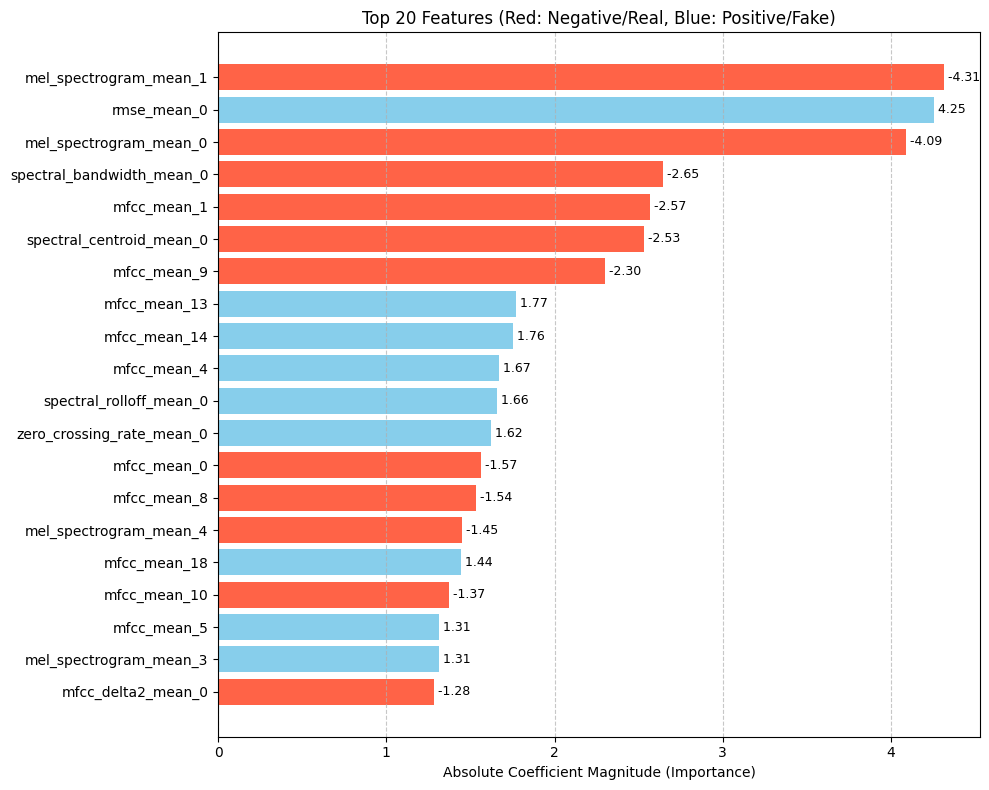

In [ ]:

train_data_path = os.path.join(FEATURES_DIR, "training_features_mean_20_128_256_128.parquet")
X = pd.read_parquet(train_data_path)
feature_names = X.drop(columns=['label', 'filename'], errors='ignore').columns

best_model_path = os.path.join(MODELS_PATH, 'logistic_reg','exp_20260131_220429', 'model.joblib')
model = joblib.load(best_model_path)


coef_values = model['clf'].coef_[0]

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_values,
    'Abs_Importance': np.abs(coef_values)
})


top_20 = feat_df.sort_values(by='Abs_Importance', ascending=True).tail(20)


plt.figure(figsize=(10, 8))


colors = ['tomato' if x < 0 else 'skyblue' for x in top_20['Coefficient']]

plt.barh(top_20['Feature'], top_20['Abs_Importance'], color=colors)
plt.xlabel('Absolute Coefficient Magnitude (Importance)')
plt.title('Top 20 Features (Red: Negative/Real, Blue: Positive/Fake)')
plt.grid(axis='x', linestyle='--', alpha=0.7)


for i, (val, abs_val) in enumerate(zip(top_20['Coefficient'], top_20['Abs_Importance'])):
    plt.text(abs_val, i, f' {val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()